## Data Loading and Formatting

In [1]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
import itertools

# This will be useful so we can construct the corresponding mask
def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

# Create image generator and preform preprocessing
def image_gen(img_paths, mask_paths=[], img_size=(384, 384), train=True):
    # Iterate over all the image paths
    for img_path, mask_path in itertools.zip_longest(img_paths, mask_paths):
        
        # Load image and sharpen
        img = imread(img_path)
        img = resize(img, img_size)
        # Normalize it to 0-1 range
#         img = img / 255.0.  
        ##############################
        
        # Get mask information for train data
        if train:
            mask = rgb2gray(imread(mask_path))
            # Turn the mask back into a 0-1 mask
            mask = (mask >= 0.5).astype(float)
            
            # Yield the image mask pair
            yield img, mask
            
        else:
            yield img

## Metric Definitions

In [2]:
import keras.backend.tensorflow_backend as K
from keras.losses import binary_crossentropy

smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

Using TensorFlow backend.


In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras.optimizers import Adam

## Model Definition
###### Note: Max pooling replaced with convolutions

In [4]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

# IMG_SIZE = (512, 512)
IMG_SIZE = (384, 384)

# Build U-Net model
inputs = Input(IMG_SIZE+(3,))
s = BatchNormalization()(inputs) # we can learn the normalization step
s = Dropout(0.5)(s)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = Conv2D(8, kernel_size=(1,1), strides=(2,2), activation='relu', padding='same') (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = Conv2D(16, kernel_size=(1,1), strides=(2,2), activation='relu', padding='same') (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = Conv2D(32, kernel_size=(1,1), strides=(2,2), activation='relu', padding='same') (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = Conv2D(64, kernel_size=(1,1), strides=(2,2), activation='relu', padding='same') (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

# Checkpoint the best model across all training epochs based on validation dice coefficient
filepath = "DepooledUNet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]# checkpoint







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 384, 384, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 384, 384, 3)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

## Batch generator function

In [5]:
import numpy as np

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, mask_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths, mask_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            batch_img.append(img)
            mask = resize(mask, (384, 384, 1)) # Reshape masks to be (512, 512, 1)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
            batch_img, batch_mask = [], []
            
            
def test_batch_generator(img_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths, train=False)
        batch_img = []
        
        for img in ig:
            # Add the image and mask to the batch
            batch_img.append(img)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0)
                batch_img = []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0)
            batch_img = []

## Train Model

In [6]:
from keras.models import load_model

filepath = "DepooledUNet.hdf5"
model.load_weights(filepath)

In [7]:
def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

In [8]:
import os
import multiprocessing
from glob import glob
BATCHSIZE = 50
num_cores = multiprocessing.cpu_count()

path_to_test = 'data/test'
glob_test_imgs = os.path.join(path_to_test, '*_sat.jpg')
glob_test_masks = os.path.join(path_to_test, '*_msk.png')

test_img_paths = sorted(glob(glob_test_imgs))
test_mask_paths = sorted(glob(glob_test_masks))

evaluate_gen = image_batch_generator(test_img_paths, test_mask_paths)

In [9]:
metrics = model.evaluate_generator(evaluate_gen, steps=calc_steps(len(test_img_paths), BATCHSIZE),
                                     workers=num_cores, use_multiprocessing=True, verbose=1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:293: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


33/33 [==============================] - 34s 1s/step


In [10]:
print(model.metrics_names)
print(metrics)

['loss', 'dice_coef']
[0.45528315233461786, 0.6199810667471453]


In [11]:
testgen = test_batch_generator(test_img_paths)

In [12]:
predicted_masks = model.predict_generator(testgen, steps=calc_steps(len(test_img_paths), BATCHSIZE),
                                     workers=num_cores, use_multiprocessing=True, verbose=1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training_generator.py:398: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


33/33 [==============================] - 25s 756ms/step


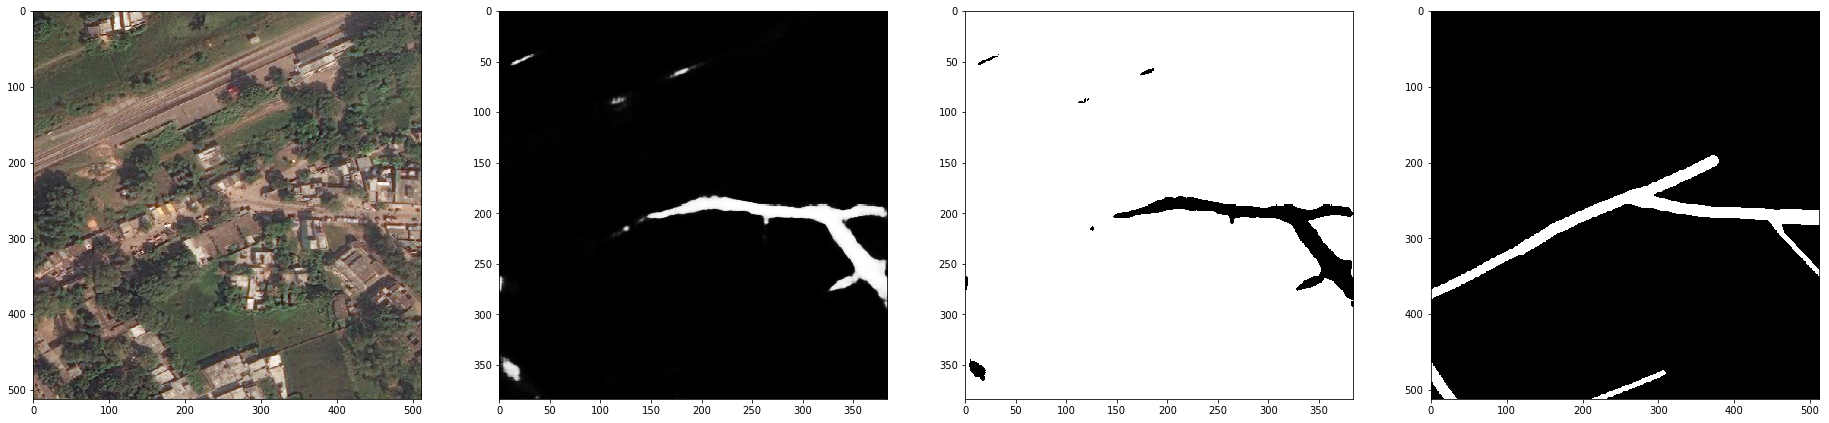

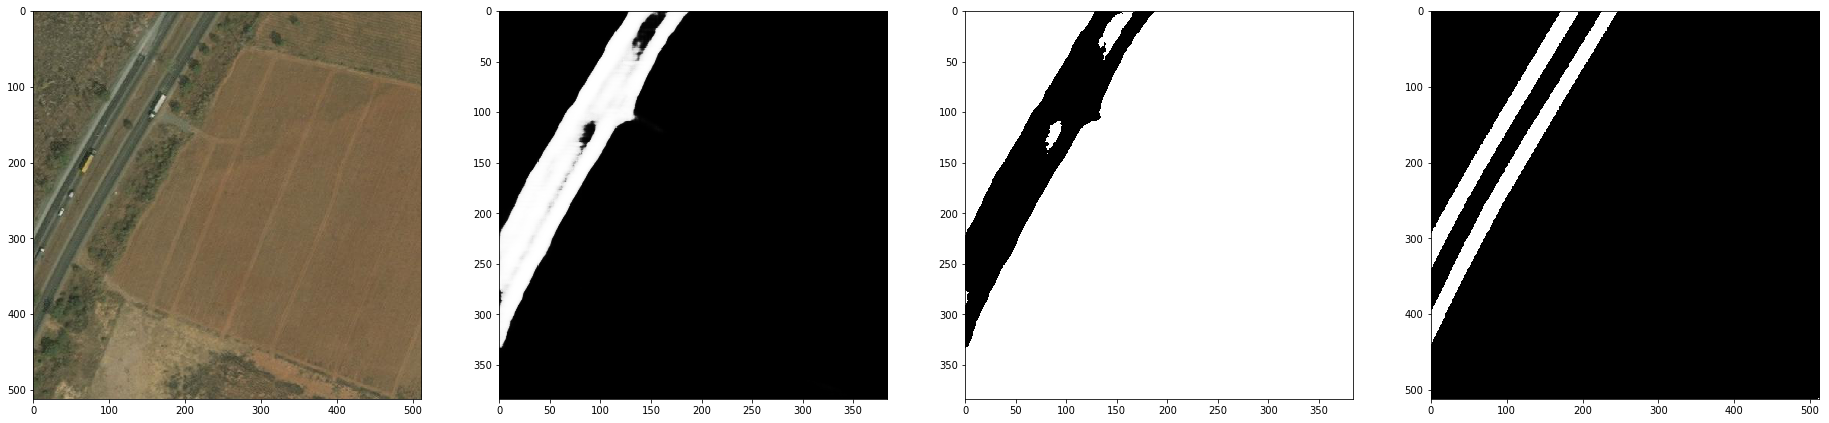

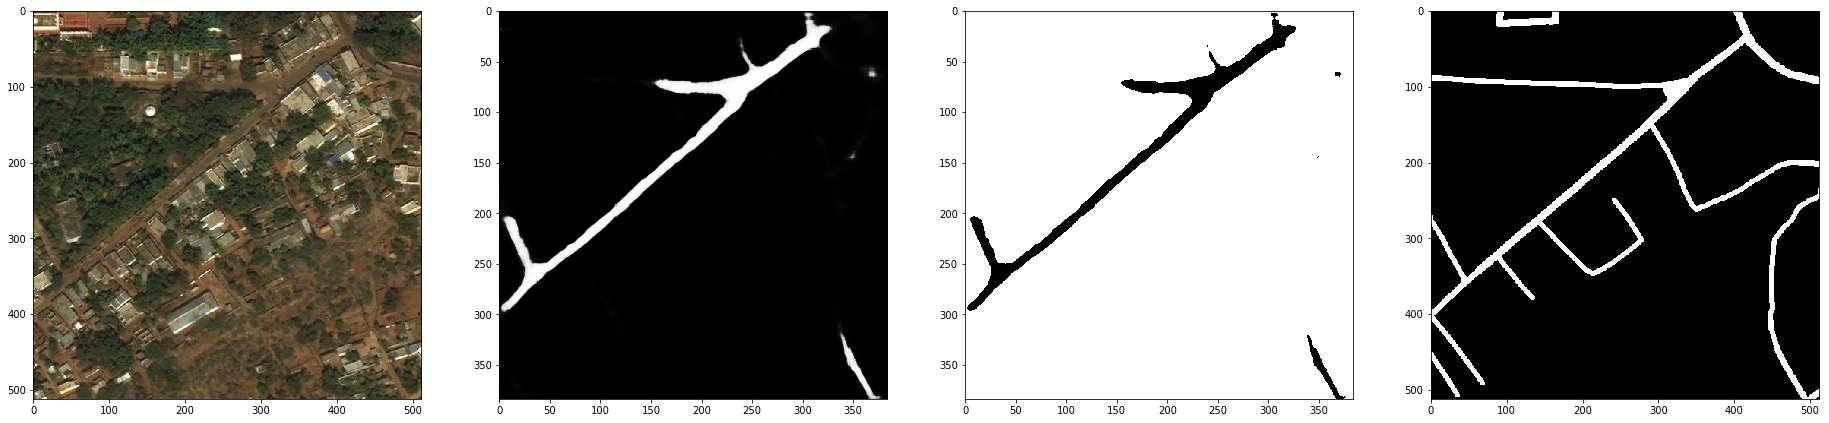

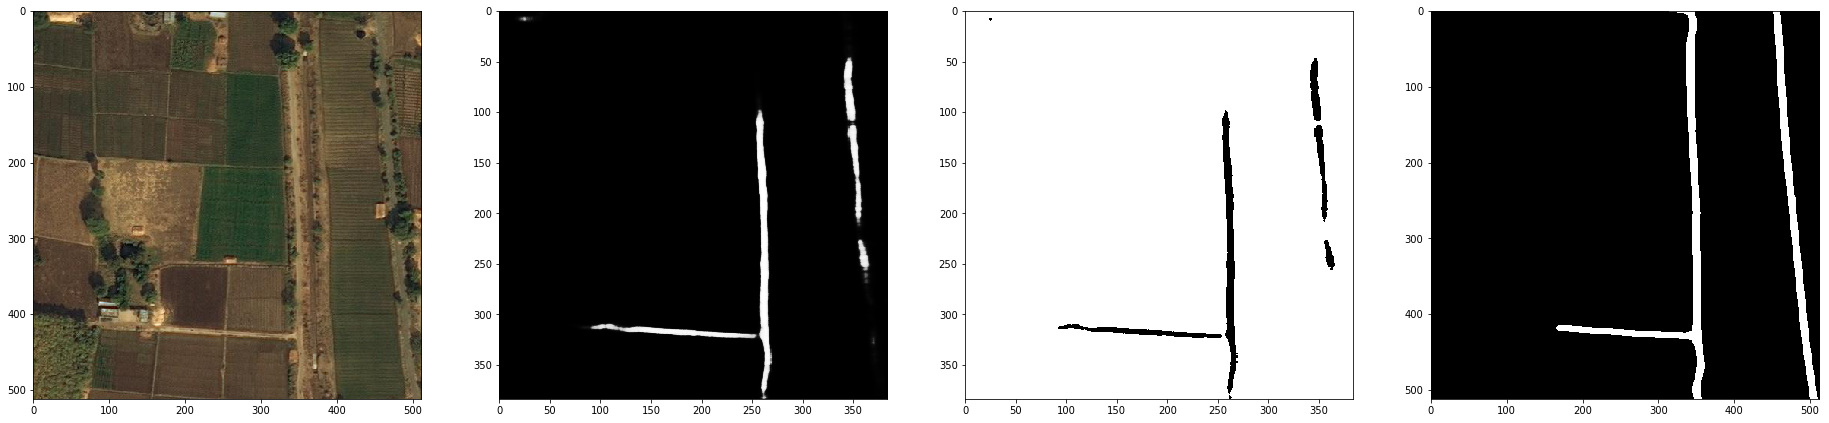

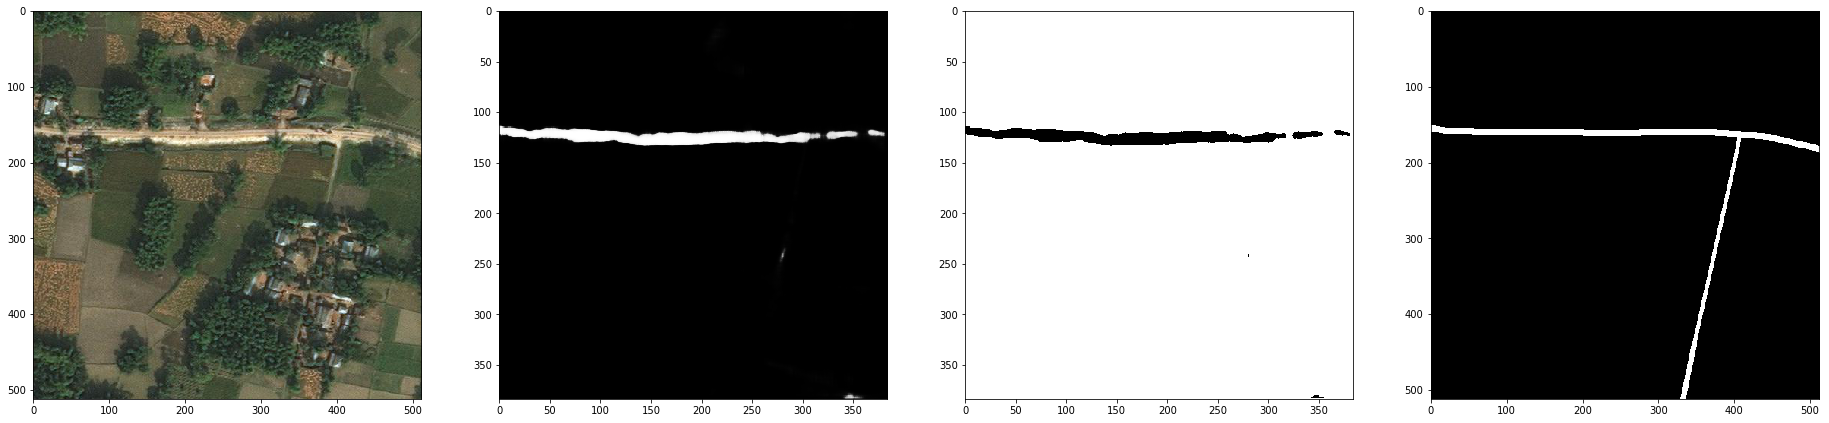

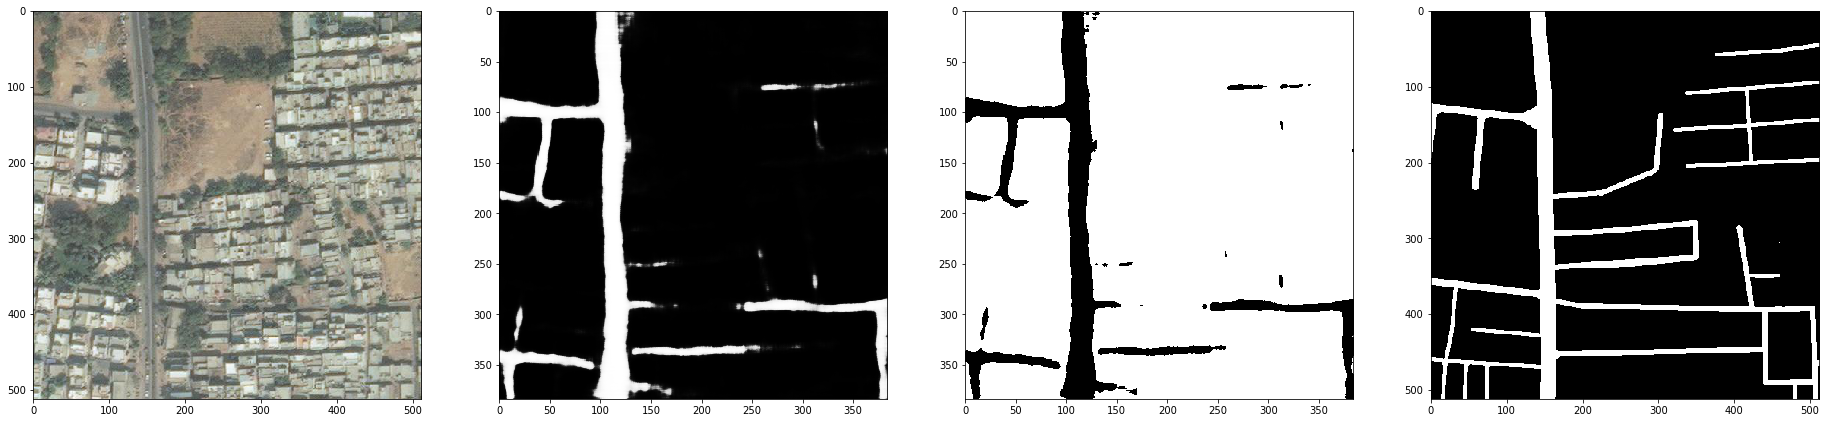

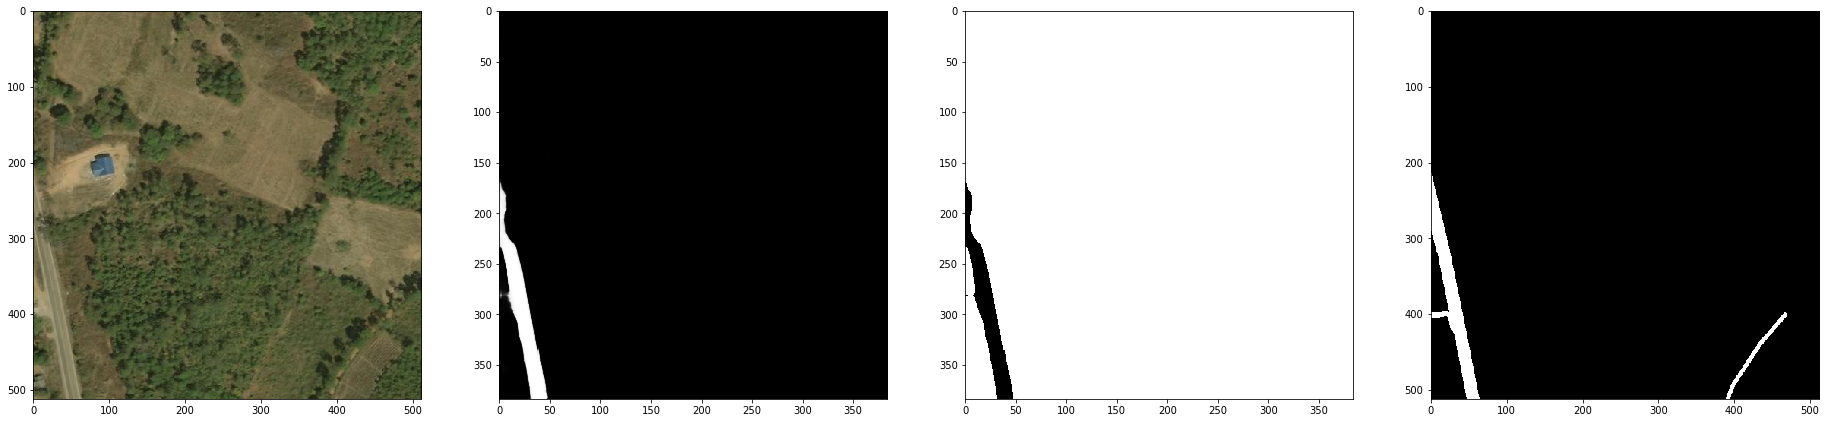

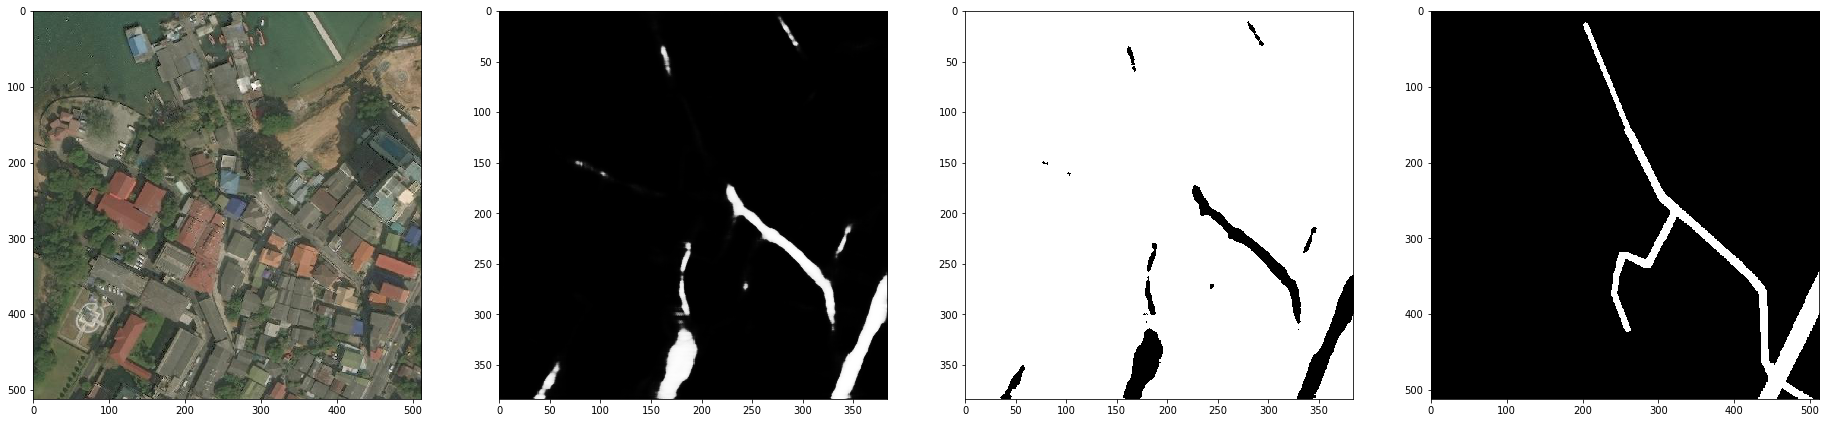

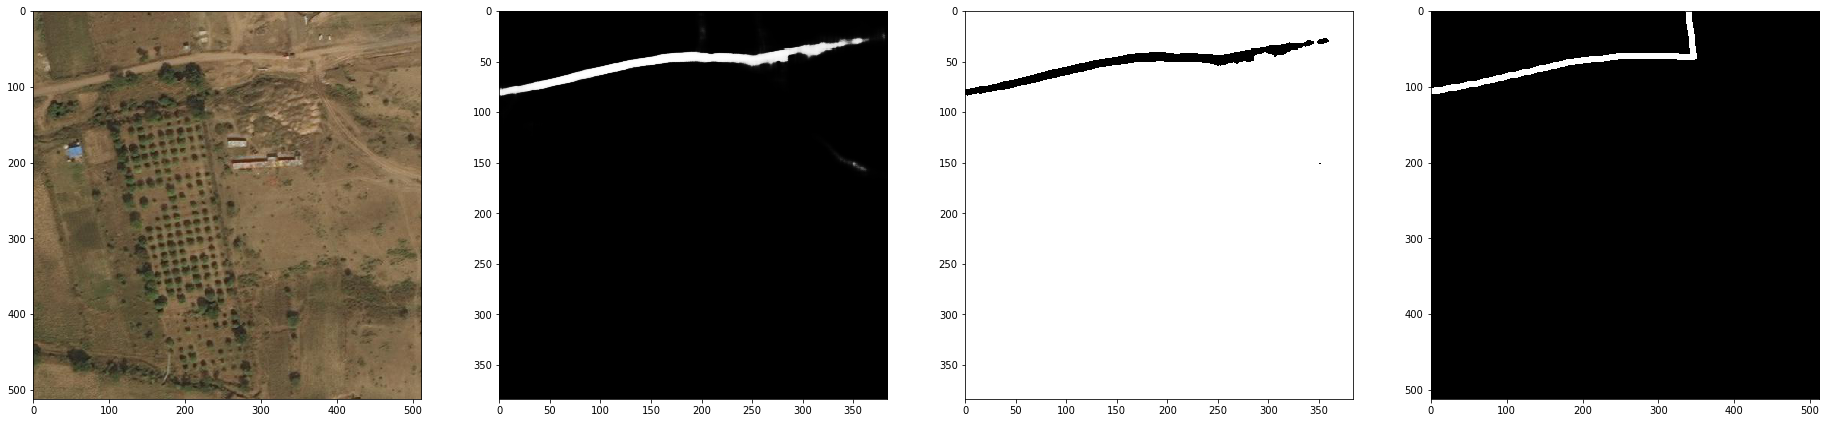

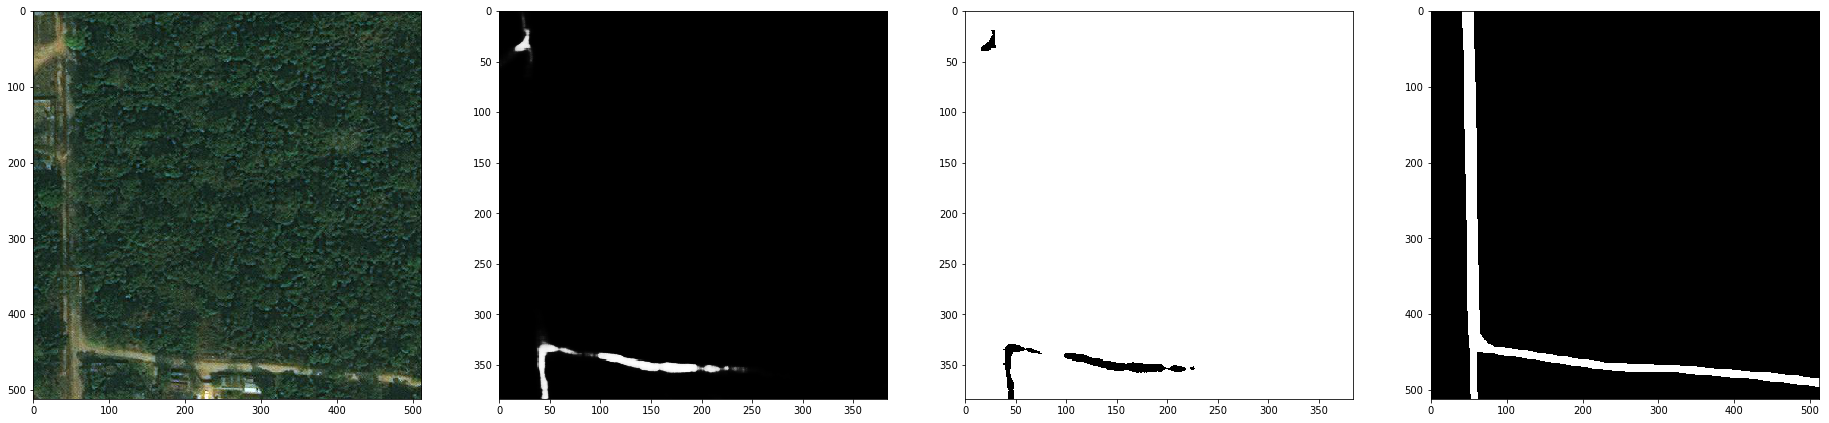

In [14]:
import matplotlib.pyplot as plt

minP = np.min(predicted_masks)
maxP = np.max(predicted_masks)

for i in range(10):
    pred_mask = predicted_masks[i] 
    
    normed_pred_mask = (predicted_masks[i] - minP) / (maxP-minP)
    normed_pred_mask = normed_pred_mask.reshape(384, 384)
    im = plt.imread(test_img_paths[i])
    true_mask = plt.imread(test_mask_paths[i])
    
    fig, axes = plt.subplots(1, 4, figsize=(32,32))
    axes[0].imshow(im)
    axes[1].imshow(normed_pred_mask, plt.cm.gray)
    axes[2].imshow(normed_pred_mask < 0.5, plt.cm.gray)
    axes[3].imshow(true_mask)

In [21]:
minP = np.min(predicted_masks)
maxP = np.max(predicted_masks)

for i in range(10):
    pred_mask = predicted_masks[i] 
    
    normed_pred_mask = (predicted_masks[i] - minP) / (maxP-minP)
    normed_pred_mask = normed_pred_mask.reshape(384, 384)
    plt.imsave("DePoolNetPredMask{}".format(i), normed_pred_mask, cmap='gray')

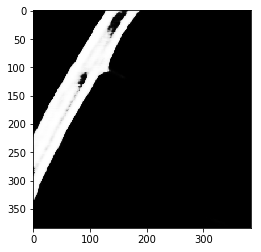

In [22]:
someIm = plt.imread("DePoolNetPredMask1.png")
plt.imshow(someIm)